# Cut-it

En este proyecto la idea es desarrollar un algorithmo de segmentación de imagenes a color, utilizando el Mean  Sift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## Algoritmo de mean-shift

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## Algoritmo basado en grafos.

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu eexplica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree # fast K-neighbors queries
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel as pairwise_gaussian_similarity
# for display in cells
from IPython.display import clear_output
from sys import stdout 
from scipy.sparse.linalg import eigsh as SquareSymmetricEigenvalues
%matplotlib inline

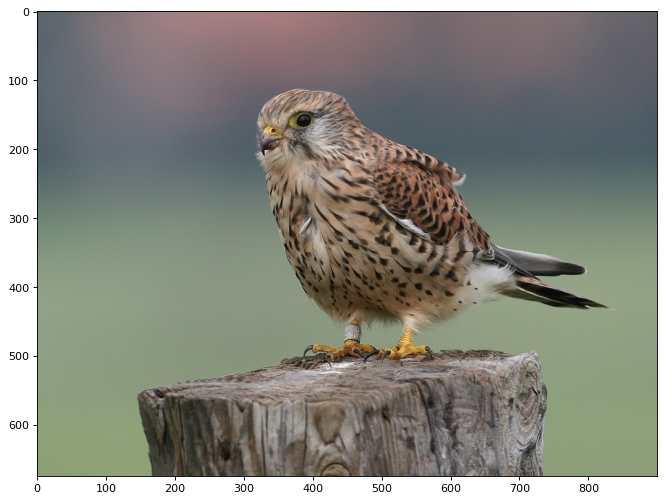

In [2]:
bird = cv2.cvtColor(cv2.imread('imgs/bird.jpg'), cv2.COLOR_BGR2RGB)

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(bird)

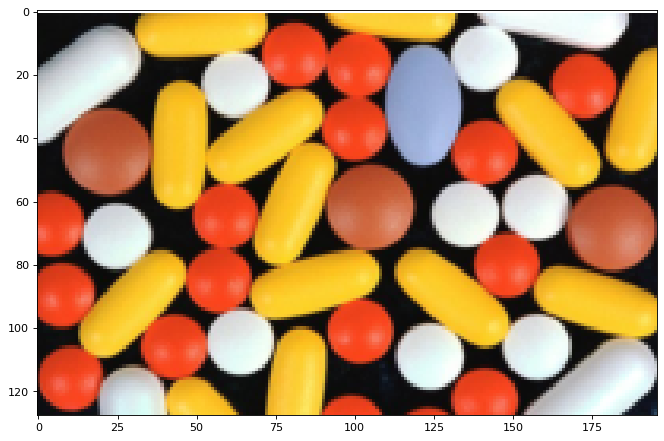

In [3]:
pills = cv2.cvtColor(cv2.imread('imgs/pills.png'), cv2.COLOR_BGR2RGB)

plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(pills)

In [4]:
def mean_shift(pts, radius , shift_stop_dist = 1e-3, mix_convergence=1e-3,  geometric_mean=True, max_iters = int(10e5), display_error=True):
    # make points positive 
    if geometric_mean:
        offset = pts.min(axis=0)
        pts = (pts - offset) + 1
    
    def mass_center(ipts, geometric=True):
        if geometric:
            return np.exp(np.mean(np.log(ipts), axis=0))
        else:
            return np.mean(ipts, axis=0)

    tree = BallTree(pts)
    prev_mean = None
    pts_mean = pts.copy()

    iters = 0
    donemask = np.zeros(len(pts), dtype=bool)

    while True:
        # Only update and calculate those who are NOT done.
        prev_mean = pts_mean.copy()
        idx = tree.query_radius(pts_mean[~donemask], r=radius)
        
        pts_mean[~donemask] = np.array([mass_center(pts[i], geometric=geometric_mean) for i in idx])

        # Calculate average shift
        if display_error:
            shifted = np.mean(np.linalg.norm(prev_mean[~donemask] - pts_mean[~donemask], axis=1))
        

        donemask[~donemask] = np.linalg.norm(prev_mean[~donemask] - pts_mean[~donemask], axis=1) < shift_stop_dist

        if display_error:
            clear_output()
            stdout.write(f"Average shift distance: {shifted}")
            stdout.flush()

        if np.all(donemask):
            break

        iters += 1
        if iters >= max_iters:
            break
        

    tagged = {}
    temp_tree = BallTree(pts_mean)
    centroids = []
    curr_class = 0
    for i in range(len(pts_mean)): # Linear in convergence of classes, still kind of slow just due to it being raw python
        if tagged.get(i) is not None:
            continue
        res = temp_tree.query_radius(pts_mean[i].reshape(1, -1), r=mix_convergence)[0]

        centroids.append(pts_mean[i])
        tagged[i] = curr_class
        # print(res)
        for k in res:
            tagged[k] = curr_class
        curr_class += 1

    if geometric_mean:
        return np.array(centroids) + offset - 1 , [tagged[i] for i in range(len(pts_mean))]
    else:
        return np.array(centroids), [tagged[i] for i in range(len(pts_mean))]


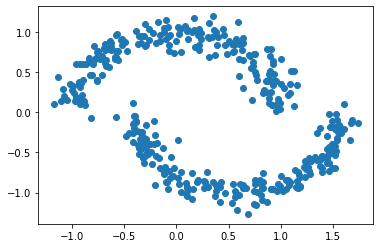

In [5]:
rng = np.random.default_rng(42)

N = 200
t = rng.random([N, 1]) * np.pi
t2 = rng.random([N, 1]) * np.pi + np.pi

pts1 = np.column_stack([np.cos(t), np.sin(t)])
pts2 = np.column_stack([np.cos(t2), np.sin(t2)])

pts2[:,0] += 0.6

# noisify.-
pts1 += rng.normal(scale=0.1,size=[N, 2])
pts2 += rng.normal(scale=0.1,size=[N, 2])


pts = np.row_stack([pts1, pts2])
plt.scatter(pts[:,0], pts[:,1])
plt.show()

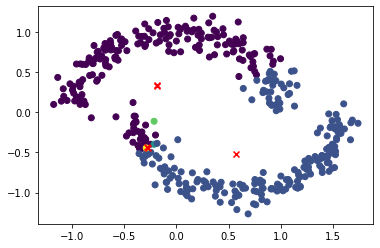

In [6]:
centroids, labels = mean_shift(pts, radius=1.2, geometric_mean=True, display_error =False)
plt.scatter(pts[:,0],pts[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red')

In [7]:
## Wrapper Helper labspace functions
def img2space(img, cv2space):
    original_shape = img.shape
    if img.dtype == np.float32 or img.dtype == np.float64:
        img = img.astype(np.float32)
        return cv2.cvtColor((img.reshape(-1,1,3) * 255).astype(np.uint8), cv2space).reshape(original_shape) / 255
    return cv2.cvtColor(img.reshape(-1,1,3), cv2space).reshape(original_shape)
  
def lab2rgb(img):
    return img2space(img, cv2.COLOR_LAB2RGB)

def rgb2lab(img):
    return img2space(img, cv2.COLOR_RGB2LAB)

def rgb2luv(img):
    return img2space(img, cv2.COLOR_RGB2LUV)

def luv2rgb(img):
    return img2space(img, cv2.COLOR_LUV2RGB)

In [8]:
def position_extend_mat(mat, weight = 1):
    n,m, _ = np.shape(mat)
    X,Y = np.meshgrid(np.linspace(0, 1, m), np.linspace(0,1, n))
    helpmat = np.zeros((mat.shape[0], mat.shape[1], mat.shape[2] + 2))
    helpmat[:,:,:mat.shape[2]] = mat
    helpmat[:,:,-2] = X * weight
    helpmat[:,:,-1] = Y * weight
    return helpmat
    
def img2R5(input_img, normalize=True, dist_scale=1, color_scale=1, space = 'rgb'):

  if input_img.max() > 1 and normalize:
    help_img = input_img.astype('float32') / 255
  else:
    help_img = input_img.copy()

  if space == 'rgb':
    pass
  elif space == 'luv':
    help_img = rgb2luv(help_img)
  elif space == 'lab':
    help_img = rgb2lab(help_img)
  else:
    raise ValueError(f'Invalid Space flag {space}')

  help_img = help_img*color_scale # either expand or make colors closers.
  help_img = position_extend_mat(help_img, dist_scale)
  return help_img.reshape(-1,5)

def img2R3(input_img, normalize=True, only_color=True, dist_scale=1, color_scale=1, space='rgb'):

  if normalize and input_img.max() > 1:
    img = input_img.astype('float32') / 255
  else:
    img = input_img.copy()

  if space == 'rgb':
    pass
  elif space == 'luv':
    img = rgb2luv(img)
  elif space == 'lab':
    img = rgb2lab(img)
  else:
    raise ValueError(f'Invalid Space flag {space}')
  
  img = img * color_scale
  if only_color:
    return img.reshape(-1,3)
  else:
    img = img.mean(axis=2)
    img = img.reshape(img.shape[0],img.shape[1],1)
    return position_extend_mat(img, dist_scale).reshape(-1,3)
    

In [9]:
def get_region_splits(img, labels):
    matlabels = np.array(labels).reshape(img.shape[0],img.shape[1])
    regionimgs = []
    for region in range(matlabels.max() + 1):
        regionmask = matlabels == region
        regionimg = np.zeros(np.shape(img), dtype=img.dtype)
        regionimg[regionmask] = img[regionmask]

        regionimgs.append(regionimg)

    return regionimgs

def get_region_quantized(img, labels, centroids, scale_centroids = 255):
    matlabels = np.reshape(np.array(labels), [img.shape[0], img.shape[1]])
    display = img.copy()
    for label in range(matlabels.max() + 1):
        display[matlabels == label] = centroids[label] * scale_centroids
    return display

def get_image_splitted(img, labels, border_color = [255,255,255], thickness=2):
    matlabels = np.reshape(np.array(labels), [img.shape[0], img.shape[1]])
    display = img.copy()
    dilate_kernel = np.ones((thickness, thickness), 'uint8')
    for label in range(matlabels.max() + 1):
        regionmask = matlabels == label
        regionedges = cv2.Canny(regionmask.astype('uint8')*255, 80, 200)
        dilated_edges_img = cv2.dilate(regionedges,dilate_kernel, iterations=1)
        
        display[dilated_edges_img == 255] = border_color

    return display

## Pills

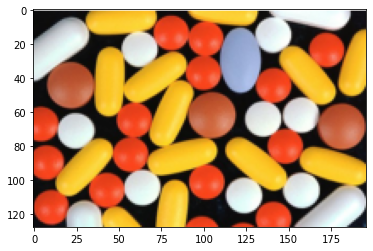

In [10]:
plt.imshow(pills)

In [11]:
pills3dpts = img2R3(pills, only_color=True)

In [12]:
centroids, labels = mean_shift(pills3dpts, radius=0.3, shift_stop_dist = 0.01, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.0052673122845590115

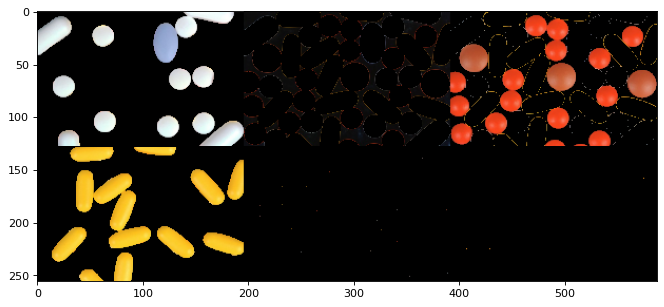

In [13]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
plt.figure(num=None, figsize=(10, 10), dpi=80)
plt.imshow(np.row_stack([
  np.column_stack(regionimgs[:3]),
  np.column_stack(regionimgs[3:]),
]))

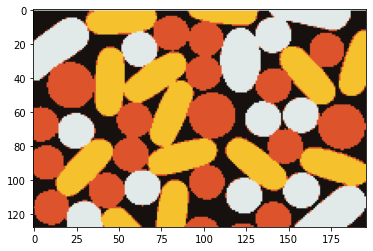

In [14]:
%matplotlib inline
quantized = get_region_quantized(pills, labels, centroids)
plt.imshow(quantized)

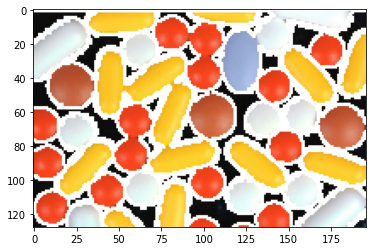

In [15]:
splitted = get_image_splitted(pills, labels)
plt.imshow(splitted)

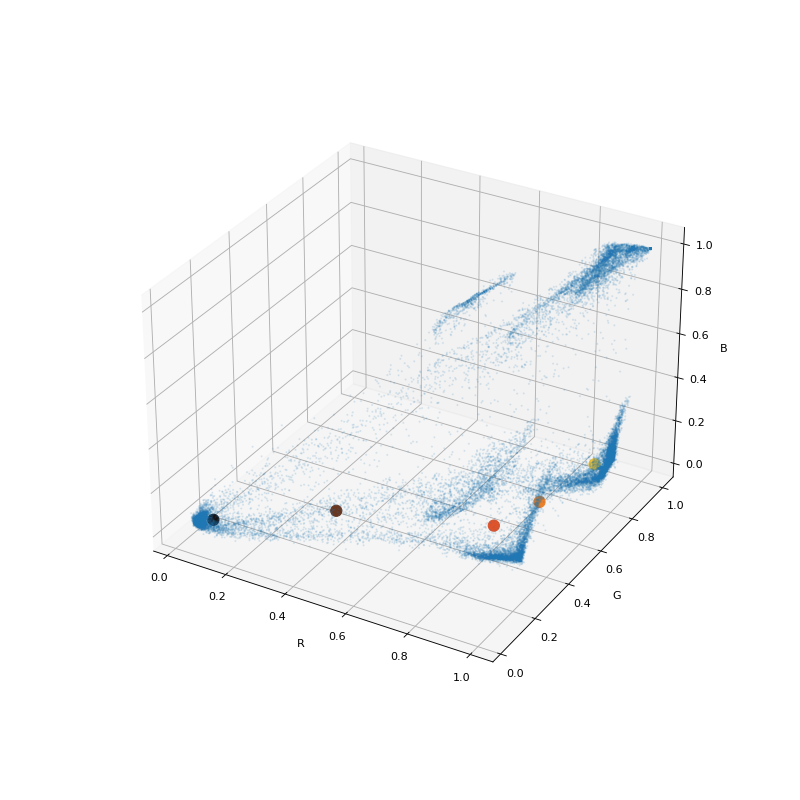

In [16]:
%matplotlib widget
fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('R'); ax.set_ylabel('G'); ax.set_zlabel('B');
ax.scatter(pills3dpts[:,0], pills3dpts[:,1],pills3dpts[:,2], alpha=0.1, s=1)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='o', color=centroids, s=100, alpha=1)

### Using LUV-space

In [17]:
pills3dptsluv = img2R3(pills, space='luv')

In [18]:
centroids, labels = mean_shift(pills3dptsluv, radius=0.1, shift_stop_dist = 1e-3, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.0007210301820982511

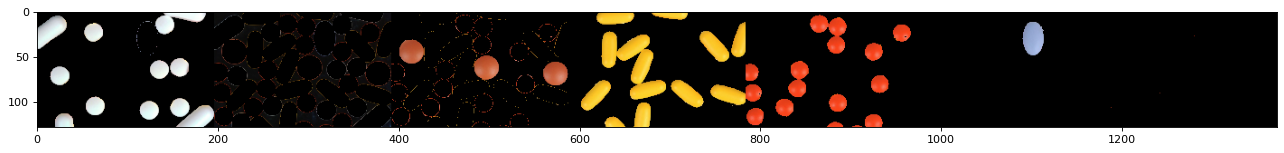

In [19]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
plt.figure(num=None, figsize=(20, 10), dpi=80)
plt.imshow(np.column_stack(regionimgs[:20]))

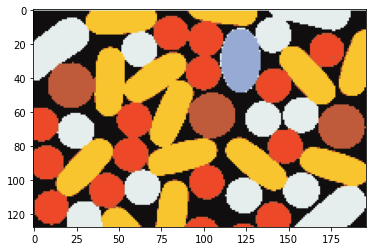

In [20]:
quantized = get_region_quantized(pills, labels, luv2rgb(centroids))
plt.imshow(quantized)

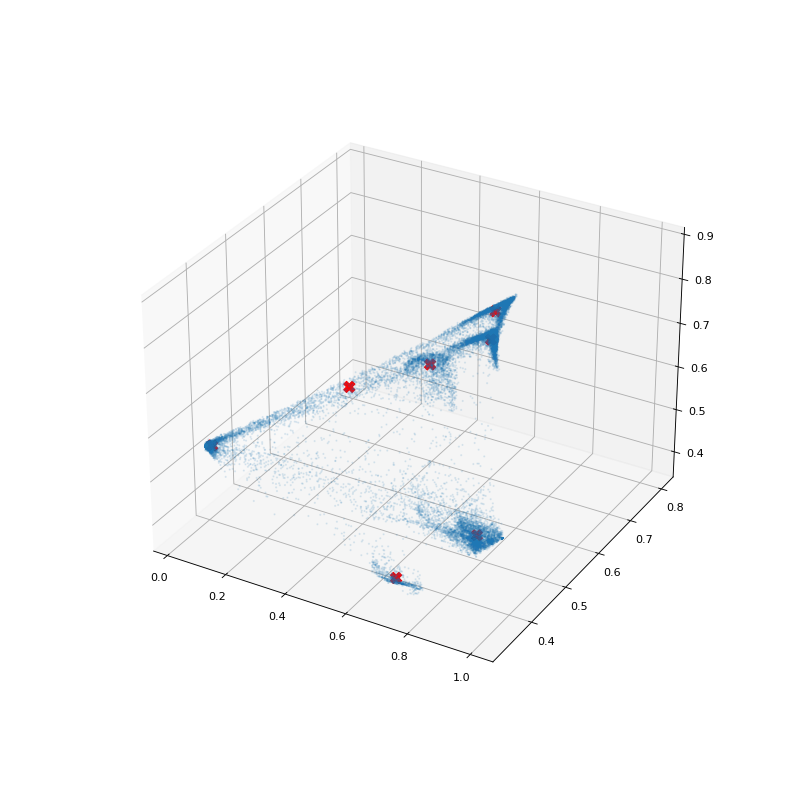

In [21]:
%matplotlib widget
fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')


ax.scatter(pills3dptsluv[:,0], pills3dptsluv[:,1],pills3dptsluv[:,2], alpha=0.1, s=1)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='X', color='red', s=100, alpha=1)

## Pills - Position Included

In [22]:
pills5d = img2R5(pills, dist_scale=2.85, color_scale=0.5, space='luv')

In [23]:
centroids, labels = mean_shift(pills5d, radius=0.25, shift_stop_dist = 1e-4, geometric_mean=False, mix_convergence=0.1)

Average shift distance: 0.0

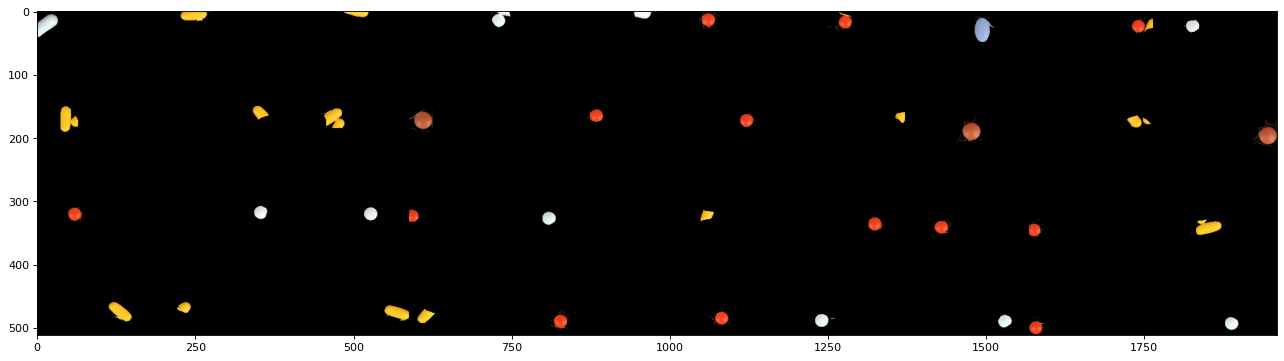

In [24]:
%matplotlib inline
regionimgs = get_region_splits(pills, labels)
nonblackregions = [reg for reg in regionimgs if reg.mean() > 1]
plt.figure(num=None, figsize=(20, 20), dpi=80)
displayblock = np.row_stack([
    np.column_stack(nonblackregions[0:10]),
    np.column_stack(nonblackregions[10:20]),
    np.column_stack(nonblackregions[20:30]),
    np.column_stack(nonblackregions[30:40]),
    ]
)

plt.imshow(displayblock)

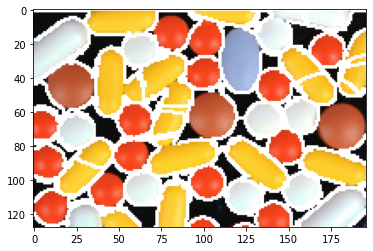

In [25]:
splitted = get_image_splitted(pills, labels, thickness=2)
plt.imshow(splitted)

## Bird

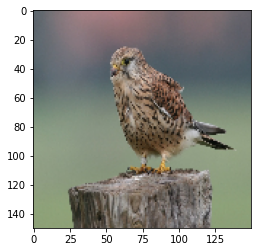

In [26]:
%matplotlib inline
smallbird = cv2.resize(bird, dsize=(150,150))

plt.imshow(smallbird)

In [27]:
bird3dpts = img2R3(smallbird, space='luv')

In [28]:
centroids, labels = mean_shift(bird3dpts, radius=0.06, shift_stop_dist=1e-4, mix_convergence=0.01, geometric_mean=False)

Average shift distance: 6.727242211033063e-05

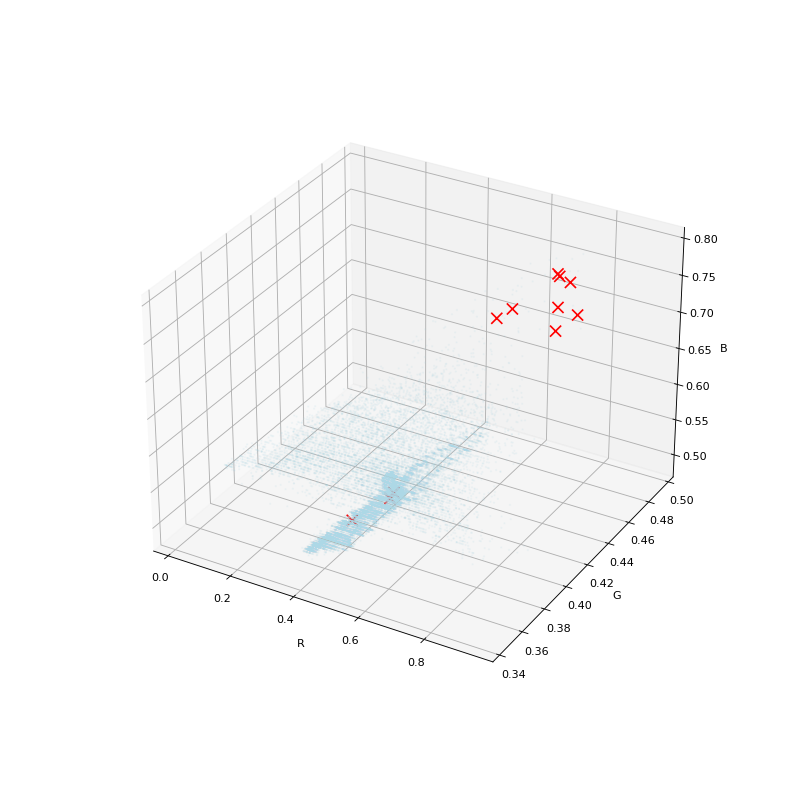

In [29]:
%matplotlib widget
fig = plt.figure(num=None, figsize=(10, 10), dpi=80)
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('R'); ax.set_ylabel('G'); ax.set_zlabel('B');
ax.scatter(bird3dpts[:,0], bird3dpts[:,1],bird3dpts[:,2], alpha=0.1, s=1, color='lightblue')
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='x', color='red', s=100, alpha=1)

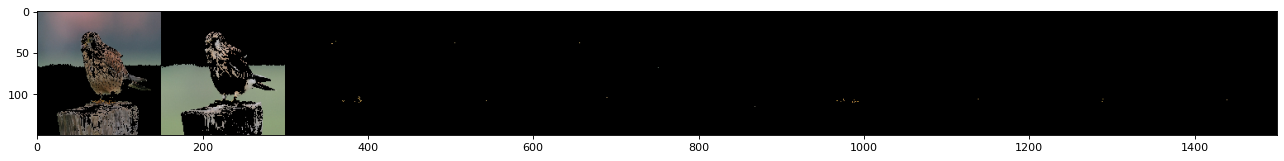

In [30]:
%matplotlib inline
imgregions = get_region_splits(smallbird, labels)

plt.figure(num=None, figsize=(20, 20), dpi=80)

displayblock = np.row_stack([
    np.column_stack(imgregions[0:10]),
    # np.column_stack(imgregions[10:20]),
    # np.column_stack(imgregions[20:30]),
    ]
)

plt.imshow(displayblock)

## SuperPixel Tuning

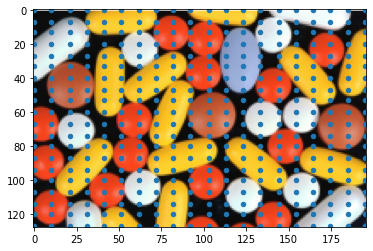

In [31]:
def uniform_initialize(img, m_samples = 100, n_samples = 100, normalize=True, display=True, display_size=0.5):
  n,m,_ = np.shape(img)
  # take uniform startup

  # there will be a total of m_samples * n_samples superpixels

  xpixels =  np.round(np.linspace(0,1,m_samples) * (m - 1)).astype('int')
  ypixels =  np.round(np.linspace(0,1,n_samples) * (n - 1)).astype('int')

  pts = np.transpose([np.tile(xpixels, len(ypixels)), np.repeat(ypixels, len(xpixels))]) # performs a cartesian product
  
  if display:
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.scatter(pts[:,0],pts[:,1], s=display_size)
    plt.show()

  
  if normalize:
    return np.column_stack(
      [img[pts[:,1], pts[:,0]] / 255, 
                  pts[:,1] / (n - 1), pts[:,0] / (m - 1)])
  
  return np.column_stack([img[pts[:,1], pts[:,0]], pts])

m_samples, n_samples = 20, 20
startpoints = uniform_initialize(pills, m_samples, n_samples, display_size=20)

In [32]:
def superpixelize(img, m_samples, n_samples, space='rgb', max_iter = 300):
  startpoints = uniform_initialize(img, m_samples, n_samples, display=False)
  clusterer = KMeans(n_clusters=m_samples*n_samples, init=startpoints, random_state=42, n_init=1, verbose=0, max_iter=max_iter)
  clusterer.fit(img2R5(img, space=space))
  return clusterer.cluster_centers_, clusterer.labels_

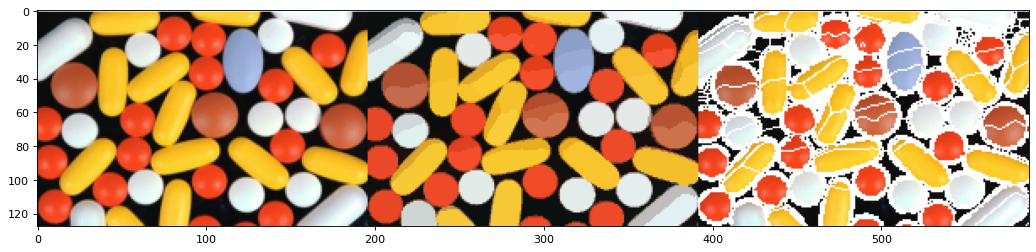

In [158]:
superpixels, superpixel_labeling = superpixelize(pills, 20, 20, space='luv')

quantized = get_region_quantized(pills, superpixel_labeling, luv2rgb(superpixels[:,:3]))
splitted = get_image_splitted(pills, superpixel_labeling, thickness=1)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack([pills, quantized, splitted]))

In [34]:
def NormalizedSpectralClustering(pts, sigma, k = 4):
  weights = pairwise_gaussian_similarity(pts, gamma=1/(2*sigma*sigma))
  D = np.diag(weights.sum(axis=0))

  Dm12 = np.sqrt(np.linalg.inv(D))
  Lsym = np.eye(np.shape(D)[0]) - Dm12 @ weights @ Dm12

  eigenvalues, eigenvectors = np.linalg.eig(Lsym)

  np.allclose(np.imag(eigenvalues), np.zeros(eigenvalues.shape)), 'Complex eigenvalues, numerical error'
  np.allclose(np.imag(eigenvectors), np.zeros(eigenvectors.shape)), 'Complex eigenvalues, numerical error'

  eigenvalues = np.real(eigenvalues)
  eigenvectors = np.real(eigenvectors)
  
  sortedindexes = eigenvalues.argsort()

  T = eigenvectors[:,sortedindexes[:k]]
  T = T/np.linalg.norm(T, axis=1, keepdims=True)

  clusterer2 = KMeans(n_clusters = k)
  clusterer2.fit(T) 

  return clusterer2.labels_

In [167]:
### Parameters
k = 50
sigma = np.mean(np.var(superpixels,axis=0))

superlabels = NormalizedSpectralClustering(superpixels, sigma, k)
img_labels = superlabels[superpixel_labeling]

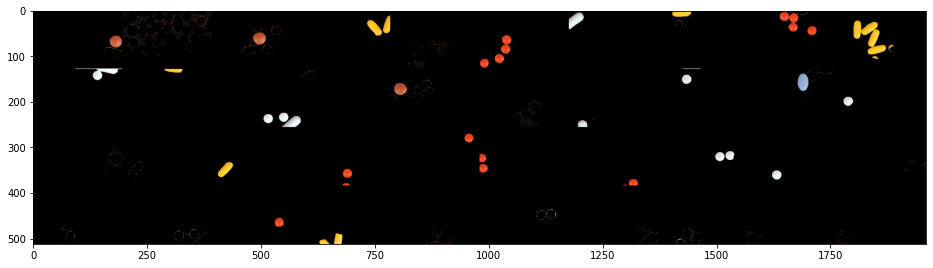

In [172]:
regionimgs = get_region_splits(pills, img_labels)

plt.figure(figsize=(16,12))
plt.imshow(np.row_stack([
  np.column_stack(regionimgs[:10]),
  np.column_stack(regionimgs[10:20]),
  np.column_stack(regionimgs[20:30]),
  np.column_stack(regionimgs[30:40])
]))

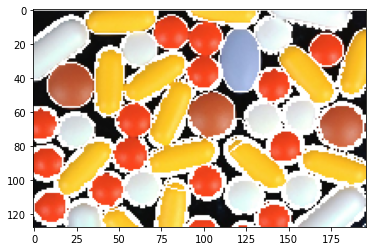

In [169]:
plt.imshow(get_image_splitted(pills, img_labels, thickness=1))

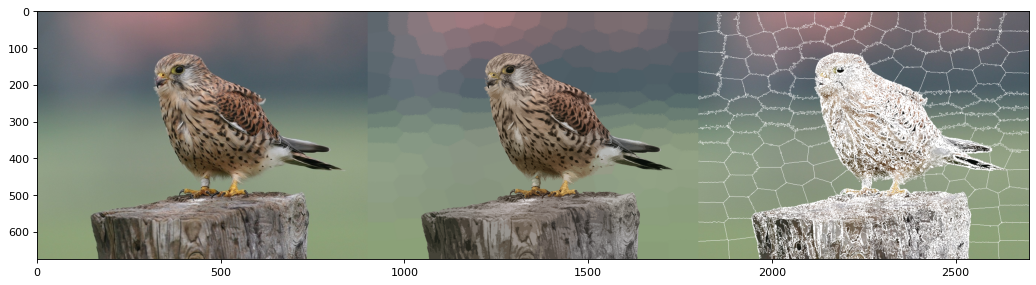

In [86]:
superpixels, superpixel_labeling = superpixelize(bird, 20, 20, space='luv')


quantized = get_region_quantized(bird, superpixel_labeling, luv2rgb(superpixels[:,:3]))
splitted = get_image_splitted(bird, superpixel_labeling, thickness=1)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack([bird, quantized, splitted]))

In [109]:
k = 3
sigma = 10
superlabels = NormalizedSpectralClustering(superpixels, sigma, k)
img_labels = superlabels[superpixel_labeling]

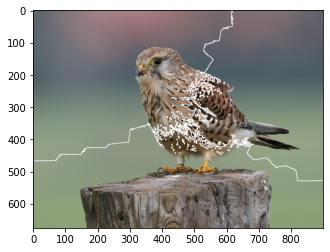

In [110]:
plt.imshow(get_image_splitted(bird, img_labels))

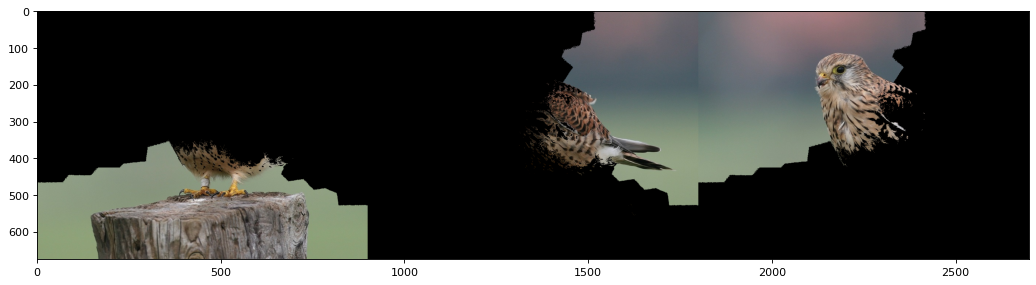

In [111]:
regionimgs = get_region_splits(bird, img_labels)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack(regionimgs))

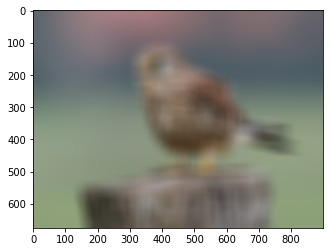

In [112]:
blurbird = cv2.blur(bird,(49,49),0)
plt.imshow(blurbird)

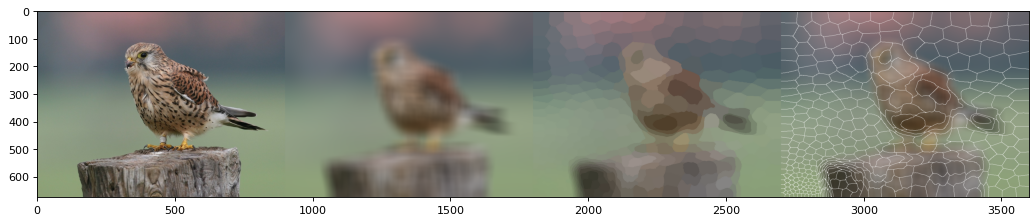

In [113]:
superpixels, superpixel_labeling = superpixelize(blurbird, 20, 20, space='luv')


quantized = get_region_quantized(blurbird, superpixel_labeling, luv2rgb(superpixels[:,:3]))
splitted = get_image_splitted(blurbird, superpixel_labeling, thickness=1)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack([bird, blurbird, quantized, splitted]))

In [153]:
k = 6
sigma = 5
superlabels = NormalizedSpectralClustering(superpixels, sigma, k)
img_labels = superlabels[superpixel_labeling]

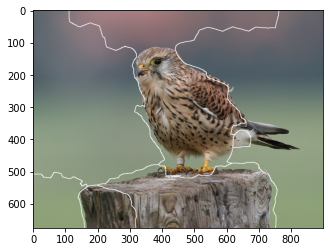

In [154]:
plt.imshow(get_image_splitted(bird, img_labels))

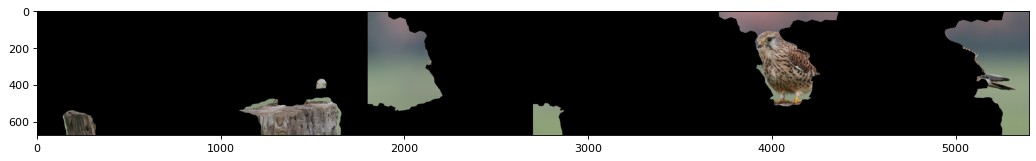

In [155]:
regionimgs = get_region_splits(bird, img_labels)

plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.imshow(np.column_stack(regionimgs))

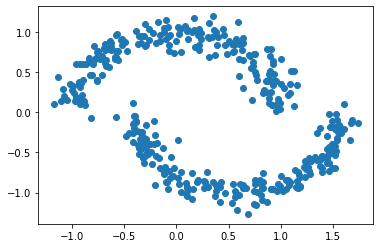

In [173]:
plt.scatter(pts[:,0], pts[:,1])
plt.show()

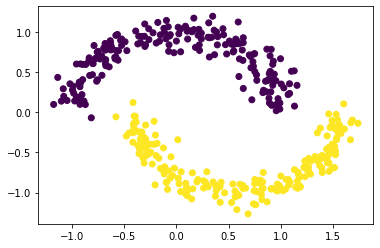

In [178]:
labels = NormalizedSpectralClustering(pts, sigma=0.1, k=2)
plt.scatter(pts[:,0],pts[:,1], c=labels)